## **Stackoverflow - Natural Language Processing**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

**[1. Lecture des données](#lecture)**

**[2. Preprocessing](#EDA)**

  * [2.1. CreationDate](#CreationDate)
  * [2.2. Tags](#Tags)
  * [2.3. Title](#Title)
      * [2.3.1. Tokenization](#Tokens)
      * [2.3.2. Lemmatization](#Lemma)
  * [2.4. Body](#Body)

**[3. Analyse Exploratoire](#EDA)**

**[4. Approche Supervisée](#Supervisée)**
  * [4.1. Bag of Words](#bow)
  * [4.2. TF-IDF](#tfidf)
  * [4.3. Dimensinality Reduction](#reduction)
  * [4.4. Models](#models)

**[5. Approche Non-Supervisée](#NonSupervisée)**
  * [5.1. LDA Multicore with Gensim](#lda)

**[6. Hugging Face: Transformers](#NonSupervisée)**

**[7. Keras using Words Embeddings](#NonSupervisée)**

**[8. API Creation](#comparaison)**

 

# Data fetching

<h2> Recupération des données

Nous devons faire des requêtes SQL dans stack explorer pour récupérer des données utilisables. Pour le moment nous récupérons les données que pour un mois. Une fois que nous avons une version plus stable, nous augmenterons le nombre de données. 

SELECT TOP(100000) Id, CreationDate, Score, ViewCount, AnswerCount, CommentCount, FavoriteCount, Title, Body, Tags
FROM Posts
WHERE CreationDate BETWEEN CONVERT(datetime, '2020-01-01') AND CONVERT(datetime, '2020-07-01')
AND Score IS NOT NULL
AND ViewCount IS NOT NULL
AND AnswerCount IS NOT NULL
AND CommentCount IS NOT NULL
AND FavoriteCount IS NOT NULL
ORDER BY ViewCount DESC

<h2> Lecture des données
    <a name='lecture'>

In [2]:
from itertools import chain
from datetime import datetime
from stackoverflow_utils import *
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

2021-12-01 12:26:32.154604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 12:26:32.154620: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
db = pd.read_csv('./Input_database/200k_QueryResults.csv')

In [4]:
db.head()

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,"Error message ""DevTools failed to load SourceM...",<p>I'm trying to display an image selected fro...,<javascript><html>
1,61205390,2020-04-14 10:19:16,78,323357,12,8,13,"When adding a JavaScript library, Chrome compl...","<h3>My code</h3>\n<pre class=""lang-html pretty...",<google-chrome-devtools>
2,59823283,2020-01-20 12:26:53,114,266124,15,0,47,Could not load dynamic library 'cudart64_101.d...,<p>I just installed the latest version of Tens...,<python><python-3.x><tensorflow><keras><tensor...
3,60296873,2020-02-19 09:24:42,109,253667,32,7,29,SessionNotCreatedException: Message: session n...,<p>I am currently new to robot framework.I am ...,<selenium><google-chrome><selenium-webdriver><...
4,60290309,2020-02-18 22:24:39,176,247270,30,3,18,error NG6002: Appears in the NgModule.imports ...,<p>First time using firestore and I'm getting ...,<angular><google-cloud-firestore><angularfire>


Dans un premier temps, pour des questions de simplicité, on va concentret sur les colonnes Tags et Titles uniquement

In [5]:
db.shape

(200000, 10)

In [6]:
#n_sample = 50000
#db = db.sample(n_sample,random_state=42)
#db = db.reset_index(drop=True)

# Preprocessing

Par simplicité, faisons ces tranformations sur une seule de ces données. Nous scalerons ensuite ces transformations via une fonction

In [7]:
sample = db.iloc[0,:]
sample

Id                                                        61339968
CreationDate                                   2020-04-21 09:16:35
Score                                                          147
ViewCount                                                   387745
AnswerCount                                                     12
CommentCount                                                     5
FavoriteCount                                                   29
Title            Error message "DevTools failed to load SourceM...
Body             <p>I'm trying to display an image selected fro...
Tags                                            <javascript><html>
Name: 0, dtype: object

Les données nécessitant une transformation sont: Creation date, Title, Body, et Tags. 

## Preprocessing de la colonne Tags

In [8]:
type(sample['Tags'])

str

In [9]:
tag_list = db['Tags'].apply(lambda x: tags_cleaner(x))

In [10]:
tag_list

0                                        [javascript, html]
1                                  [google-chrome-devtools]
2         [python, python-3.x, tensorflow, keras, tensor...
3         [selenium, google-chrome, selenium-webdriver, ...
4            [angular, google-cloud-firestore, angularfire]
                                ...                        
199995     [outlook, office-js, add-in, outlook-web-addins]
199996                                       [loops, vlang]
199997                                            [reactjs]
199998               [java, maven, intellij-idea, getgauge]
199999                              [sql, oracle, auditing]
Name: Tags, Length: 200000, dtype: object

In [11]:
db['Tags'] = tag_list
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,"Error message ""DevTools failed to load SourceM...",<p>I'm trying to display an image selected fro...,"[javascript, html]"
1,61205390,2020-04-14 10:19:16,78,323357,12,8,13,"When adding a JavaScript library, Chrome compl...","<h3>My code</h3>\n<pre class=""lang-html pretty...",[google-chrome-devtools]
2,59823283,2020-01-20 12:26:53,114,266124,15,0,47,Could not load dynamic library 'cudart64_101.d...,<p>I just installed the latest version of Tens...,"[python, python-3.x, tensorflow, keras, tensor..."
3,60296873,2020-02-19 09:24:42,109,253667,32,7,29,SessionNotCreatedException: Message: session n...,<p>I am currently new to robot framework.I am ...,"[selenium, google-chrome, selenium-webdriver, ..."
4,60290309,2020-02-18 22:24:39,176,247270,30,3,18,error NG6002: Appears in the NgModule.imports ...,<p>First time using firestore and I'm getting ...,"[angular, google-cloud-firestore, angularfire]"
...,...,...,...,...,...,...,...,...,...,...
199995,57402803,2019-08-07 22:01:57,0,599,1,0,1,Outlook office-js how to forward selected emai...,"<p>I am new to outlook office-js, and I am try...","[outlook, office-js, add-in, outlook-web-addins]"
199996,56952330,2019-07-09 12:11:49,5,599,2,1,1,Loop through an array in vlang,<p>How can I loop over an array of strings on ...,"[loops, vlang]"
199997,59194296,2019-12-05 11:36:52,0,599,3,7,1,How to hide Navbar in Login Component with Rea...,<p>Recently I started learning React and my pr...,[reactjs]
199998,56847354,2019-07-02 07:26:35,2,599,1,0,1,Unsupported Gauge Version: This veuge Inrsion ...,<p>//unexpected gauge plugin error comes </...,"[java, maven, intellij-idea, getgauge]"


In [12]:
tags_count = pd.Series(chain(*tag_list)).value_counts()
tags_top_500 = tags_count.nlargest(500)
tags_top_500

python                    28675
javascript                19046
java                      12791
reactjs                   11925
android                   11540
                          ...  
data-science                174
angular-reactive-forms      172
random                      172
frontend                    172
serialization               172
Length: 500, dtype: int64

In [13]:
len(tags_count)

23559

In [14]:
tester = list(tags_top_500.keys())


Let's first clean the Tags column, by keeping the most common value only for each row

In [15]:
db['Tags'] = db['Tags'].apply(lambda x: most_common_selector(tags_top_500,x))
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,"Error message ""DevTools failed to load SourceM...",<p>I'm trying to display an image selected fro...,"[javascript, html]"
1,61205390,2020-04-14 10:19:16,78,323357,12,8,13,"When adding a JavaScript library, Chrome compl...","<h3>My code</h3>\n<pre class=""lang-html pretty...",[]
2,59823283,2020-01-20 12:26:53,114,266124,15,0,47,Could not load dynamic library 'cudart64_101.d...,<p>I just installed the latest version of Tens...,"[python, python-3.x, tensorflow, keras, tensor..."
3,60296873,2020-02-19 09:24:42,109,253667,32,7,29,SessionNotCreatedException: Message: session n...,<p>I am currently new to robot framework.I am ...,"[selenium, google-chrome, selenium-webdriver, ..."
4,60290309,2020-02-18 22:24:39,176,247270,30,3,18,error NG6002: Appears in the NgModule.imports ...,<p>First time using firestore and I'm getting ...,"[angular, google-cloud-firestore]"
...,...,...,...,...,...,...,...,...,...,...
199995,57402803,2019-08-07 22:01:57,0,599,1,0,1,Outlook office-js how to forward selected emai...,"<p>I am new to outlook office-js, and I am try...",[]
199996,56952330,2019-07-09 12:11:49,5,599,2,1,1,Loop through an array in vlang,<p>How can I loop over an array of strings on ...,[loops]
199997,59194296,2019-12-05 11:36:52,0,599,3,7,1,How to hide Navbar in Login Component with Rea...,<p>Recently I started learning React and my pr...,[reactjs]
199998,56847354,2019-07-02 07:26:35,2,599,1,0,1,Unsupported Gauge Version: This veuge Inrsion ...,<p>//unexpected gauge plugin error comes </...,"[java, maven, intellij-idea]"


Now, we would like to keep only the rows where the most common 200 tags are present

In [16]:
index_to_drop = []
for index, value in enumerate(db['Tags']):
    if len(value)==0:
        index_to_drop.append(index)       

In [17]:
len(index_to_drop)

9142

In [18]:
db.drop(index_to_drop, inplace=True)
db.reset_index(drop=True, inplace=True)

In [19]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,"Error message ""DevTools failed to load SourceM...",<p>I'm trying to display an image selected fro...,"[javascript, html]"
1,59823283,2020-01-20 12:26:53,114,266124,15,0,47,Could not load dynamic library 'cudart64_101.d...,<p>I just installed the latest version of Tens...,"[python, python-3.x, tensorflow, keras, tensor..."
2,60296873,2020-02-19 09:24:42,109,253667,32,7,29,SessionNotCreatedException: Message: session n...,<p>I am currently new to robot framework.I am ...,"[selenium, google-chrome, selenium-webdriver, ..."
3,60290309,2020-02-18 22:24:39,176,247270,30,3,18,error NG6002: Appears in the NgModule.imports ...,<p>First time using firestore and I'm getting ...,"[angular, google-cloud-firestore]"
4,59601077,2020-01-05 14:54:15,189,244810,20,2,34,IntelliJ: Error:java: error: release version 5...,<p>I'm using <strong>IntelliJ IDEA Ultimate 20...,"[java, intellij-idea]"
...,...,...,...,...,...,...,...,...,...,...
190853,57799149,2019-09-05 05:52:02,2,599,0,1,2,What are the reasons for XMLHTTPRequest Networ...,<p>I have a React frontend that's hooked up to...,[javascript]
190854,56952330,2019-07-09 12:11:49,5,599,2,1,1,Loop through an array in vlang,<p>How can I loop over an array of strings on ...,[loops]
190855,59194296,2019-12-05 11:36:52,0,599,3,7,1,How to hide Navbar in Login Component with Rea...,<p>Recently I started learning React and my pr...,[reactjs]
190856,56847354,2019-07-02 07:26:35,2,599,1,0,1,Unsupported Gauge Version: This veuge Inrsion ...,<p>//unexpected gauge plugin error comes </...,"[java, maven, intellij-idea]"


## Preprocessing de la colonne Title

<h4> Tokenisation
         <a name="Tokens">

In [20]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import tensorflow as tf

[nltk_data] Downloading package stopwords to /home/efkant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
stop_words = set(stopwords.words('english'))

In [22]:
regularizer = lambda x : re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      x)

In [23]:
db['Title'] = db['Title'].apply(lambda x: regularizer(x))

In [24]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,Error message DevTools failed to load SourceM...,<p>I'm trying to display an image selected fro...,"[javascript, html]"
1,59823283,2020-01-20 12:26:53,114,266124,15,0,47,Could not load dynamic library cudart d...,<p>I just installed the latest version of Tens...,"[python, python-3.x, tensorflow, keras, tensor..."
2,60296873,2020-02-19 09:24:42,109,253667,32,7,29,SessionNotCreatedException Message session n...,<p>I am currently new to robot framework.I am ...,"[selenium, google-chrome, selenium-webdriver, ..."
3,60290309,2020-02-18 22:24:39,176,247270,30,3,18,error NG Appears in the NgModule imports ...,<p>First time using firestore and I'm getting ...,"[angular, google-cloud-firestore]"
4,59601077,2020-01-05 14:54:15,189,244810,20,2,34,IntelliJ Error java error release version ...,<p>I'm using <strong>IntelliJ IDEA Ultimate 20...,"[java, intellij-idea]"
...,...,...,...,...,...,...,...,...,...,...
190853,57799149,2019-09-05 05:52:02,2,599,0,1,2,What are the reasons for XMLHTTPRequest Networ...,<p>I have a React frontend that's hooked up to...,[javascript]
190854,56952330,2019-07-09 12:11:49,5,599,2,1,1,Loop through an array in vlang,<p>How can I loop over an array of strings on ...,[loops]
190855,59194296,2019-12-05 11:36:52,0,599,3,7,1,How to hide Navbar in Login Component with Rea...,<p>Recently I started learning React and my pr...,[reactjs]
190856,56847354,2019-07-02 07:26:35,2,599,1,0,1,Unsupported Gauge Version This veuge Inrsion ...,<p>//unexpected gauge plugin error comes </...,"[java, maven, intellij-idea]"


In [25]:
# This tokenizer, makes tokens, put tokens in lower case and remove punctuations
db['Title'] = db['Title'].apply(lambda x: tokenizer(x))

In [26]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,"[error, message, devtools, failed, to, load, s...",<p>I'm trying to display an image selected fro...,"[javascript, html]"
1,59823283,2020-01-20 12:26:53,114,266124,15,0,47,"[could, not, load, dynamic, library, cudart, d...",<p>I just installed the latest version of Tens...,"[python, python-3.x, tensorflow, keras, tensor..."
2,60296873,2020-02-19 09:24:42,109,253667,32,7,29,"[sessionnotcreatedexception, message, session,...",<p>I am currently new to robot framework.I am ...,"[selenium, google-chrome, selenium-webdriver, ..."
3,60290309,2020-02-18 22:24:39,176,247270,30,3,18,"[error, ng, appears, in, the, ngmodule, import...",<p>First time using firestore and I'm getting ...,"[angular, google-cloud-firestore]"
4,59601077,2020-01-05 14:54:15,189,244810,20,2,34,"[intellij, error, java, error, release, versio...",<p>I'm using <strong>IntelliJ IDEA Ultimate 20...,"[java, intellij-idea]"
...,...,...,...,...,...,...,...,...,...,...
190853,57799149,2019-09-05 05:52:02,2,599,0,1,2,"[what, are, the, reasons, for, xmlhttprequest,...",<p>I have a React frontend that's hooked up to...,[javascript]
190854,56952330,2019-07-09 12:11:49,5,599,2,1,1,"[loop, through, an, array, in, vlang]",<p>How can I loop over an array of strings on ...,[loops]
190855,59194296,2019-12-05 11:36:52,0,599,3,7,1,"[how, to, hide, navbar, in, login, component, ...",<p>Recently I started learning React and my pr...,[reactjs]
190856,56847354,2019-07-02 07:26:35,2,599,1,0,1,"[unsupported, gauge, version, this, veuge, inr...",<p>//unexpected gauge plugin error comes </...,"[java, maven, intellij-idea]"


In [27]:
db['Title'] = db['Title'].apply(lambda x:stop_words_check(x,stop_words))

In [28]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,"[error, message, devtools, failed, load, sourc...",<p>I'm trying to display an image selected fro...,"[javascript, html]"
1,59823283,2020-01-20 12:26:53,114,266124,15,0,47,"[could, load, dynamic, library, cudart, dll, t...",<p>I just installed the latest version of Tens...,"[python, python-3.x, tensorflow, keras, tensor..."
2,60296873,2020-02-19 09:24:42,109,253667,32,7,29,"[sessionnotcreatedexception, message, session,...",<p>I am currently new to robot framework.I am ...,"[selenium, google-chrome, selenium-webdriver, ..."
3,60290309,2020-02-18 22:24:39,176,247270,30,3,18,"[error, appears, ngmodule, imports, appmodule,...",<p>First time using firestore and I'm getting ...,"[angular, google-cloud-firestore]"
4,59601077,2020-01-05 14:54:15,189,244810,20,2,34,"[intellij, error, java, error, release, versio...",<p>I'm using <strong>IntelliJ IDEA Ultimate 20...,"[java, intellij-idea]"
...,...,...,...,...,...,...,...,...,...,...
190853,57799149,2019-09-05 05:52:02,2,599,0,1,2,"[reasons, xmlhttprequest, network, error, occu...",<p>I have a React frontend that's hooked up to...,[javascript]
190854,56952330,2019-07-09 12:11:49,5,599,2,1,1,"[loop, array, vlang]",<p>How can I loop over an array of strings on ...,[loops]
190855,59194296,2019-12-05 11:36:52,0,599,3,7,1,"[hide, navbar, login, component, reactjs]",<p>Recently I started learning React and my pr...,[reactjs]
190856,56847354,2019-07-02 07:26:35,2,599,1,0,1,"[unsupported, gauge, version, veuge, inrsion, ...",<p>//unexpected gauge plugin error comes </...,"[java, maven, intellij-idea]"


<h4> Lemmatization
         <a name="Lemma">


In [29]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/efkant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
def list_lemmatizer(list_to_lem):
    return [lemmatizer.lemmatize(token, 'v') for token in list_to_lem]

In [31]:
db['Title'] = db['Title'].apply(lambda x: list_lemmatizer(x))

In [32]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,"[error, message, devtools, fail, load, sourcem...",<p>I'm trying to display an image selected fro...,"[javascript, html]"
1,59823283,2020-01-20 12:26:53,114,266124,15,0,47,"[could, load, dynamic, library, cudart, dll, t...",<p>I just installed the latest version of Tens...,"[python, python-3.x, tensorflow, keras, tensor..."
2,60296873,2020-02-19 09:24:42,109,253667,32,7,29,"[sessionnotcreatedexception, message, session,...",<p>I am currently new to robot framework.I am ...,"[selenium, google-chrome, selenium-webdriver, ..."
3,60290309,2020-02-18 22:24:39,176,247270,30,3,18,"[error, appear, ngmodule, import, appmodule, c...",<p>First time using firestore and I'm getting ...,"[angular, google-cloud-firestore]"
4,59601077,2020-01-05 14:54:15,189,244810,20,2,34,"[intellij, error, java, error, release, versio...",<p>I'm using <strong>IntelliJ IDEA Ultimate 20...,"[java, intellij-idea]"
...,...,...,...,...,...,...,...,...,...,...
190853,57799149,2019-09-05 05:52:02,2,599,0,1,2,"[reason, xmlhttprequest, network, error, occur...",<p>I have a React frontend that's hooked up to...,[javascript]
190854,56952330,2019-07-09 12:11:49,5,599,2,1,1,"[loop, array, vlang]",<p>How can I loop over an array of strings on ...,[loops]
190855,59194296,2019-12-05 11:36:52,0,599,3,7,1,"[hide, navbar, login, component, reactjs]",<p>Recently I started learning React and my pr...,[reactjs]
190856,56847354,2019-07-02 07:26:35,2,599,1,0,1,"[unsupported, gauge, version, veuge, inrsion, ...",<p>//unexpected gauge plugin error comes </...,"[java, maven, intellij-idea]"


In [33]:
db['Title'] = db['Title'].apply(lambda x: " ".join(x))

In [34]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,error message devtools fail load sourcemap cou...,<p>I'm trying to display an image selected fro...,"[javascript, html]"
1,59823283,2020-01-20 12:26:53,114,266124,15,0,47,could load dynamic library cudart dll tensorfl...,<p>I just installed the latest version of Tens...,"[python, python-3.x, tensorflow, keras, tensor..."
2,60296873,2020-02-19 09:24:42,109,253667,32,7,29,sessionnotcreatedexception message session cre...,<p>I am currently new to robot framework.I am ...,"[selenium, google-chrome, selenium-webdriver, ..."
3,60290309,2020-02-18 22:24:39,176,247270,30,3,18,error appear ngmodule import appmodule could r...,<p>First time using firestore and I'm getting ...,"[angular, google-cloud-firestore]"
4,59601077,2020-01-05 14:54:15,189,244810,20,2,34,intellij error java error release version support,<p>I'm using <strong>IntelliJ IDEA Ultimate 20...,"[java, intellij-idea]"
...,...,...,...,...,...,...,...,...,...,...
190853,57799149,2019-09-05 05:52:02,2,599,0,1,2,reason xmlhttprequest network error occur shor...,<p>I have a React frontend that's hooked up to...,[javascript]
190854,56952330,2019-07-09 12:11:49,5,599,2,1,1,loop array vlang,<p>How can I loop over an array of strings on ...,[loops]
190855,59194296,2019-12-05 11:36:52,0,599,3,7,1,hide navbar login component reactjs,<p>Recently I started learning React and my pr...,[reactjs]
190856,56847354,2019-07-02 07:26:35,2,599,1,0,1,unsupported gauge version veuge inrsion gatell...,<p>//unexpected gauge plugin error comes </...,"[java, maven, intellij-idea]"


## Preprocessing de la Colonne Body

In [35]:
from bs4 import BeautifulSoup

In [36]:
db['Body'] = db['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [37]:
db['Body'] = db['Body'].apply(lambda x: clean_text(x)) 

In [38]:
db['Body'][14]

"using angular and during ng serve, i am getting the error: error from chokidar (c:\\): error: ebusy: resource busy or locked, lstat 'c:\\dumpstack.log.tmp error from chokidar (c:\\): error: ebusy: resource busy or locked, lstat 'c:\\hiberfil.sys error from chokidar (c:\\): error: ebusy: resource busy or locked, lstat 'c:\\pagefile.sys error from chokidar (c:\\): error: ebusy: resource busy or locked, lstat 'c:\\swapfile.sys"

In [39]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [40]:
db['Body'] = db['Body'].apply(lambda x: clean_punct(x,tags_top_500))

Now we have to remove the stopwords, tokenize and lemmatize the Body column

In [41]:
db['Body'] = db['Body'].apply(lambda x: tokenizer(x))

In [42]:
db['Body'] = db['Body'].apply(lambda x: stop_words_check(x,stop_words))

In [43]:
db['Body'] = db['Body'].apply(lambda x: list_lemmatizer(x))

In [44]:
db['Body'] = db['Body'].apply(lambda x: " ".join(x))

In [45]:
#Ici, on a met plus de poids sur les titres en mettant Title plusieurs fois dans la nouvelle colonne que l'on créer
db['Post'] = db['Title']+" "+db['Body']+" "+db['Title']+" "+db['Title']+" "+db['Title']

In [46]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags,Post
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,error message devtools fail load sourcemap cou...,try display image select local machine need lo...,"[javascript, html]",error message devtools fail load sourcemap cou...
1,59823283,2020-01-20 12:26:53,114,266124,15,0,47,could load dynamic library cudart dll tensorfl...,instal latest version tensorflow via pip insta...,"[python, python-3.x, tensorflow, keras, tensor...",could load dynamic library cudart dll tensorfl...
2,60296873,2020-02-19 09:24:42,109,253667,32,7,29,sessionnotcreatedexception message session cre...,currently new robot framework currently use la...,"[selenium, google-chrome, selenium-webdriver, ...",sessionnotcreatedexception message session cre...
3,60290309,2020-02-18 22:24:39,176,247270,30,3,18,error appear ngmodule import appmodule could r...,first time use firestore get error seem proble...,"[angular, google-cloud-firestore]",error appear ngmodule import appmodule could r...
4,59601077,2020-01-05 14:54:15,189,244810,20,2,34,intellij error java error release version support,use intellij idea ultimate whenever try start ...,"[java, intellij-idea]",intellij error java error release version supp...
...,...,...,...,...,...,...,...,...,...,...,...
190853,57799149,2019-09-05 05:52:02,2,599,0,1,2,reason xmlhttprequest network error occur shor...,react frontend hook sentry get quite report pa...,[javascript],reason xmlhttprequest network error occur shor...
190854,56952330,2019-07-09 12:11:49,5,599,2,1,1,loop array vlang,loop array string program language example lan...,[loops],loop array vlang loop array string program lan...
190855,59194296,2019-12-05 11:36:52,0,599,3,7,1,hide navbar login component reactjs,recently start learn react problem cannot hide...,[reactjs],hide navbar login component reactjs recently s...
190856,56847354,2019-07-02 07:26:35,2,599,1,0,1,unsupported gauge version veuge inrsion gatell...,unexpected gauge plugin error come completely ...,"[java, maven, intellij-idea]",unsupported gauge version veuge inrsion gatell...


# EDA

<h4> Exploration des variables génériques

In [47]:
import seaborn as sns

In [48]:
db.describe()

,Id,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
count,1.908580e+05,190858.000000,1.908580e+05,190858.000000,190858.000000,190858.000000
mean,5.959058e+07,4.330010,3.597220e+03,1.789760,2.160732,1.503023
std,3.325032e+06,10.973853,9.877858e+03,1.599125,2.955583,2.473346
min,5.399232e+07,-24.000000,1.240000e+02,0.000000,0.000000,0.000000
25%,5.681398e+07,1.000000,6.830000e+02,1.000000,0.000000,1.000000
50%,5.951626e+07,2.000000,1.458000e+03,1.000000,1.000000,1.000000
75%,6.263774e+07,5.000000,3.300000e+03,2.000000,3.000000,2.000000
max,6.551501e+07,693.000000,1.432498e+06,50.000000,50.000000,195.000000


In [49]:
fig = px.bar(tags_top_500.nlargest(40))
fig.show()

(0.0, 50000.0)

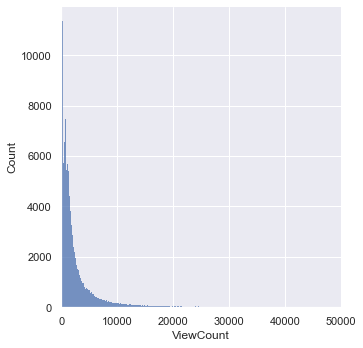

In [50]:
sns.set_theme()
ax = sns.displot(db['ViewCount'])
plt.xlim(0,50000)


(0.0, 40.0)

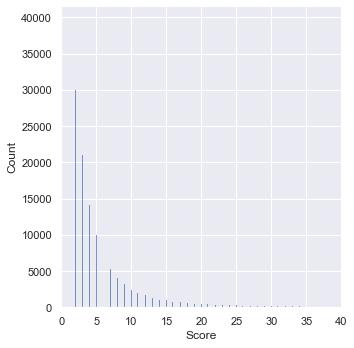

In [51]:
sns.set_theme()
ax = sns.displot(db['Score'])
plt.xlim(0,40)

(0.0, 20.0)

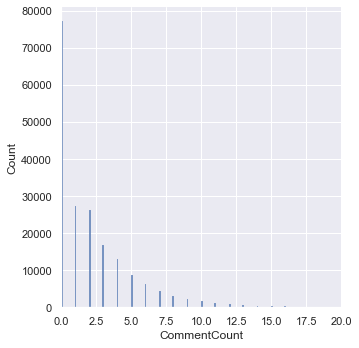

In [52]:
sns.set_theme()
ax = sns.displot(db['CommentCount'])
plt.xlim(0,20)

# Supervised Learning

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

In [54]:
X = np.array(db['Post'])
y = np.array(db['Tags'])

In [55]:
y.shape

(190858,)

In [56]:
mlb = MultiLabelBinarizer()

In [57]:
mlb.fit(y)
y_encoded = mlb.transform(y)

In [58]:
y_encoded.shape

(190858, 500)

<h4>Utilisation de Bag of Words

<a name='bow'>

In [59]:
vectorizer_X_BoW = CountVectorizer()


X_bow = vectorizer_X_BoW.fit_transform(X)

In [60]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_encoded, test_size = 0.20, random_state = 0) # Do 80/20 split

<h4> Utilisation de TF-IDF
    <a name='tfidf'>

In [61]:
vectorizer_X = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=30000)

In [62]:
X_tfidf = vectorizer_X.fit_transform(X)

In [63]:
X_tfidf.shape

(190858, 30000)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size = 0.20, random_state = 0) # Do 80/20 split

In [65]:
X_train.shape

(152686, 30000)

<h4> Dimensionality reduction
    <a name='reduction'>

In [66]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt

In [67]:
svd = TruncatedSVD(n_components=2500)
svd.fit(X_train)
#display_scree_plot(svd)

TruncatedSVD(n_components=2500)

In [68]:
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

<h4> Models 
    <a name = 'models'>

In [69]:
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score, make_scorer

In [70]:
models_performance = {}

<h4> MultiOutputClassifier approach

In [71]:
dummy = DummyClassifier()
sgd = SGDClassifier(n_jobs=-1)
svc = LinearSVC()

metrics_results = pd.DataFrame(index=["Accuracy", "F1","Jaccard", "Recall","Precision"])

for classifier in [dummy,sgd]:
    clf = MultiOutputClassifier(classifier,n_jobs=-1)
    clf.fit(X_train_svd, y_train)
    y_pred = clf.predict(X_test_svd)
    metrics_score(classifier.__class__.__name__,df=metrics_results,y_true=y_test,y_pred = y_pred)
metrics_results

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning:

`n_features_in_` is deprecated in 1.0 and will be removed in 1.2.

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,DummyClassifier,SGDClassifier
Accuracy,0.0,0.167295
F1,0.0,0.689912
Jaccard,0.0,0.338312
Recall,0.0,0.366058
Precision,0.0,0.647289


In [72]:
opt_clf = MultiOutputClassifier(sgd,n_jobs=-1)

In [73]:
opt_clf.get_params()

{'estimator__alpha': 0.0001,
 'estimator__average': False,
 'estimator__class_weight': None,
 'estimator__early_stopping': False,
 'estimator__epsilon': 0.1,
 'estimator__eta0': 0.0,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.15,
 'estimator__learning_rate': 'optimal',
 'estimator__loss': 'hinge',
 'estimator__max_iter': 1000,
 'estimator__n_iter_no_change': 5,
 'estimator__n_jobs': -1,
 'estimator__penalty': 'l2',
 'estimator__power_t': 0.5,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__tol': 0.001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': SGDClassifier(n_jobs=-1),
 'n_jobs': -1}

In [74]:
params = {
    'estimator__alpha':[1e-4, 1e-2, 1e-1],
    'estimator__l1_ratio':[0,0.1,0.2,0.5,0.8],
    'estimator__learning_rate': ['optimal'],
}

In [75]:
#grid_opt_clf = GridSearchCV(opt_clf,
#                              param_grid=params,
#                              n_jobs=-1,
#                              scoring=make_scorer(scorer_jaccard),
#                              verbose=False,
#                              cv=2,
#                              refit=True
#                             )
#grid_opt_clf.fit(X_train_svd, y_train)

In [76]:
#grid_opt_clf.best_params_, grid_opt_clf.best_score_

In [77]:
#y_pred = grid_opt_clf.predict(X_test_svd)
#metrics_score('Grid_opt_clf',df=metrics_results,y_true=y_test,y_pred = y_pred)
#metrics_score

In [78]:
metrics_results

,DummyClassifier,SGDClassifier
Accuracy,0.0,0.167295
F1,0.0,0.689912
Jaccard,0.0,0.338312
Recall,0.0,0.366058
Precision,0.0,0.647289


In [79]:
y_pred_supervised = mlb.inverse_transform(y_pred)

In [80]:
y_test_labels = mlb.inverse_transform(y_test)

In [81]:
test_labels = pd.Series(y_test_labels)
y_pred_supervised = pd.Series(y_pred_supervised)

Results = pd.concat([test_labels, y_pred_supervised], axis=1) 
Results.rename(columns={0 : 'Test labels', 1 : 'Supervised predicted labels'}, inplace=True)
Results

,Test labels,Supervised predicted labels
0,"(java, web-scraping)",()
1,"(python, python-3.x)",()
2,"(batch-file, cmd, powershell, windows)","(powershell,)"
3,"(angular, javascript, pdf)",()
4,"(android,)","(android,)"
...,...,...
38167,"(java, project-reactor, rest, spring, spring-w...","(java, spring-webflux)"
38168,"(plot, python)","(python,)"
38169,"(docker,)",()
38170,"(angular, css)","(angular,)"


# Unsupervised Learning

<h4> LDA Multicore using Gensim
    <a name="lda">

In [82]:
import gensim
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import math

In [83]:
texts = db['Post'].apply(lambda x : x.split(' '))
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=100)
bow_corpus = [id2word.doc2bow(text) for text in texts]

In [84]:
model = LdaMulticore(corpus=bow_corpus,
                            id2word=id2word,
                            num_topics=20, 
                            random_state=42,
                            passes=10,
                            workers=7)

In [85]:
coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
coherencemodel.get_coherence()

0.5990236985185835

In [86]:
perplexity = model.log_perplexity(bow_corpus)
math.pow(2,perplexity)

0.00954846150412107

In [87]:
model.print_topics()

[(0,
  '0.019*"time" + 0.013*"way" + 0.012*"would" + 0.012*"like" + 0.012*"one" + 0.008*"need" + 0.008*"data" + 0.008*"work" + 0.007*"change" + 0.007*"question"'),
 (1,
  '0.049*"self" + 0.033*"view" + 0.024*"var" + 0.019*"let" + 0.015*"video" + 0.013*"swiftui" + 0.012*"text" + 0.011*"frame" + 0.011*"func" + 0.010*"ios"'),
 (2,
  '0.048*"request" + 0.044*"api" + 0.029*"http" + 0.029*"response" + 0.027*"url" + 0.022*"get" + 0.020*"json" + 0.019*"com" + 0.018*"https" + 0.017*"error"'),
 (3,
  '0.039*"const" + 0.038*"react" + 0.034*"component" + 0.028*"import" + 0.019*"state" + 0.018*"return" + 0.016*"console" + 0.016*"export" + 0.015*"prop" + 0.014*"angular"'),
 (4,
  '0.040*"spring" + 0.038*"org" + 0.026*"springframework" + 0.024*"public" + 0.023*"boot" + 0.023*"class" + 0.022*"jar" + 0.022*"release" + 0.018*"java" + 0.017*"dependency"'),
 (5,
  '0.029*"value" + 0.026*"string" + 0.022*"list" + 0.021*"data" + 0.016*"table" + 0.015*"array" + 0.014*"name" + 0.013*"get" + 0.012*"row" + 0.01

In [88]:
import pyLDAvis.gensim_models

In [89]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, bow_corpus, id2word)
vis

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/efkant/anaconda3/envs/stack_tags/lib/py

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.175107  0.014318       1        1  8.575446
0     -0.102716 -0.128323       2        1  8.066014
18    -0.207929  0.083134       3        1  6.527872
7      0.129695 -0.125019       4        1  6.173395
11     0.124033 -0.050978       5        1  5.390295
3     -0.099535  0.036451       6        1  5.132782
2      0.029760 -0.032009       7        1  4.977164
10    -0.162049  0.077645       8        1  4.914065
8     -0.058492  0.224494       9        1  4.874527
14     0.013236 -0.118478      10        1  4.728924
19    -0.117383 -0.021220      11        1  4.667678
6     -0.049777 -0.055002      12        1  4.660931
17     0.123261 -0.089346      13        1  4.441530
15     0.165681 -0.142130      14        1  4.320652
9     -0.008549 -0.010559      15        1  4.243235
12     0.003158 -0.057453      16        1  4.168244
4      0.212883  0.228319      17        1  3.731511
16     0.285462  0.190807      18        1  3.594298
13     0.051968 -0.078842      19        1  3.513093
1     -0.157599  0.054190      20        1  3.298345, topic_info=        Term           Freq          Total Category  logprob  loglift
252     java  175796.000000  175796.000000  Default  30.0000  30.0000
17      file  243578.000000  243578.000000  Default  29.0000  29.0000
380  android  133727.000000  133727.000000  Default  28.0000  28.0000
531   python  117866.000000  117866.000000  Default  27.0000  27.0000
375      org  114434.000000  114434.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
63       try    6398.348521  156747.211843  Topic20  -5.0440   0.2132
4       code    5901.651475  146866.055017  Topic20  -5.1248   0.1975
171   import    5659.367277  147653.018411  Topic20  -5.1668   0.1502
20       get    5559.867244  232945.956850  Topic20  -5.1845  -0.3235
121      app    5408.953414  173962.607488  Topic20  -5.2120  -0.0590

[1599 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2666      1  0.889127  'a'
2666      2  0.001203  'a'
2666      3  0.012633  'a'
2666      6  0.009024  'a'
2666      8  0.001504  'a'
...     ...       ...  ...
2183     12  0.005241  zsh
2183     14  0.007862  zsh
1583     13  0.999066  └──
1583     17  0.000636  └──
1584     13  0.999836  ├──

[9115 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 19, 8, 12, 4, 3, 11, 9, 15, 20, 7, 18, 16, 10, 13, 5, 17, 14, 2])

In [90]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(model\
                             .get_document_topics(bow_corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_encoded.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (190858, 500)
document/topic :  (190858, 20)


In [91]:
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000317,0.000317,0.050186,0.057272,0.000317,0.000317,0.000317,0.080399,0.000317,0.000317,0.000317,0.000317,0.000317,0.000317,0.345097,0.000317,0.000317,0.107223,0.355391,0.000317
1,0.024367,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.674840,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.041708,0.000781,0.000781,0.000781,0.246582
2,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.489395,0.000714,0.000714,0.000714,0.000714,0.097302,0.000714,0.401158,0.000714,0.000714,0.000714,0.000714,0.000714
3,0.000126,0.000126,0.000126,0.072921,0.000126,0.000126,0.000126,0.000126,0.000126,0.000126,0.011308,0.000126,0.015034,0.000126,0.000126,0.000126,0.000126,0.898716,0.000126,0.000126
4,0.000299,0.000299,0.000299,0.000299,0.051129,0.000299,0.005426,0.665474,0.000299,0.000299,0.000299,0.000299,0.000299,0.000299,0.000299,0.000299,0.273180,0.000299,0.000299,0.000299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190853,0.324212,0.000206,0.419116,0.000206,0.000206,0.000206,0.000206,0.000989,0.000206,0.000206,0.000206,0.000206,0.042555,0.097789,0.000206,0.000206,0.000206,0.103882,0.000206,0.008780
190854,0.003334,0.003334,0.003334,0.003334,0.003334,0.936660,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334
190855,0.073660,0.000505,0.000505,0.607731,0.000505,0.000505,0.000505,0.000505,0.000505,0.132482,0.000505,0.000505,0.000505,0.000505,0.000505,0.000505,0.000505,0.000505,0.178044,0.000505
190856,0.062953,0.000276,0.000276,0.000276,0.078729,0.000276,0.000277,0.679402,0.000276,0.000276,0.000276,0.082347,0.000276,0.000276,0.030317,0.013890,0.048768,0.000276,0.000276,0.000276


In [92]:
topic_tag = np.matmul(doc_topic.T,y_encoded)

In [93]:
y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results[0].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_encoded)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results

,0,best_topic,nb_tags,y_true
0,"[javascript, html]",18,2,"[224, 248]"
1,"[python, python-3.x, tensorflow, keras, tensor...",7,5,"[262, 362, 365, 444, 445]"
2,"[selenium, google-chrome, selenium-webdriver, ...",7,4,"[200, 402, 403, 404]"
3,"[angular, google-cloud-firestore]",17,2,"[28, 202]"
4,"[java, intellij-idea]",7,2,"[235, 243]"
...,...,...,...,...
190853,[javascript],2,1,[248]
190854,[loops],5,1,[280]
190855,[reactjs],3,1,[384]
190856,"[java, maven, intellij-idea]",7,3,"[235, 243, 289]"


In [94]:
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results

,0,best_topic,nb_tags,y_true,y_pred
0,"[javascript, html]",18,2,"[224, 248]","[248, 113]"
1,"[python, python-3.x, tensorflow, keras, tensor...",7,5,"[262, 362, 365, 444, 445]","[15, 362, 238, 175, 471]"
2,"[selenium, google-chrome, selenium-webdriver, ...",7,4,"[200, 402, 403, 404]","[15, 362, 238, 175]"
3,"[angular, google-cloud-firestore]",17,2,"[28, 202]","[248, 312]"
4,"[java, intellij-idea]",7,2,"[235, 243]","[15, 362]"
...,...,...,...,...,...
190853,[javascript],2,1,[248],[248]
190854,[loops],5,1,[280],[362]
190855,[reactjs],3,1,[384],[384]
190856,"[java, maven, intellij-idea]",7,3,"[235, 243, 289]","[15, 362, 238]"


In [95]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y_encoded.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_encoded.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [96]:
df_metrics_compare = metrics_score("LDA", df=metrics_results,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,DummyClassifier,SGDClassifier,LDA
Accuracy,0.0,0.167295,0.063539
F1,0.0,0.689912,0.336445
Jaccard,0.0,0.338312,0.093766
Recall,0.0,0.366058,0.245234
Precision,0.0,0.647289,0.130146


In [97]:
#Adding the results from the Keras model
keras_results= [
  0.182490,
  0.613120,
  0.417798,
  0.554563,
  0.595299
]
df_metrics_compare['Keras'] = keras_results
df_metrics_compare

,DummyClassifier,SGDClassifier,LDA,Keras
Accuracy,0.0,0.167295,0.063539,0.182490
F1,0.0,0.689912,0.336445,0.613120
Jaccard,0.0,0.338312,0.093766,0.417798
Recall,0.0,0.366058,0.245234,0.554563
Precision,0.0,0.647289,0.130146,0.595299


# Keras with Embedding Layer

In [98]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

https://colab.research.google.com/drive/1oHB_lZ8EL7vFAZZqIzkDIcBDFyUSDOkZ#scrollTo=8FKJIprOx197

# Hugging Face Zero Shot Classification

In [99]:
from transformers import pipeline # HuggingFace Transformers Package
from tqdm import tqdm

In [100]:
classifier = pipeline("zero-shot-classification",device = 0) 

No model was supplied, defaulted to roberta-large-mnli (https://huggingface.co/roberta-large-mnli)
2021-12-01 12:49:30.948160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-01 12:49:30.948618: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-01 12:49:30.949541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (efkant-MS-7C95): /proc/driver/nvidia/version does not exist
2021-12-01 12:49:30.955769: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model

In [101]:
y_pred = []
y = []
for i in tqdm(range(10)):
   titles = db.iloc[i,]['Title']
   tags = db.iloc[i,]['Tags']
   op = classifier(titles, tags_top_500.keys())
   labels = op['labels'] 
   scores = op['scores']
   res_dict = {label : score for label,score in zip(labels, scores)}
   sorted_dict = dict(sorted(res_dict.items(), key=lambda x:x[1],reverse = True)) #sorting the dictionary of labels in descending order based on their score
   categories = []
   for i, (k,v) in enumerate(sorted_dict.items()):
     if(i > 3): #storing only the best 4 predictions
       break
     else:
       categories.append(k)
   y.append(tags)
   y_pred.append(categories)

100%|██████████| 10/10 [04:32<00:00, 27.26s/it]


In [102]:
out = pd.DataFrame(list(zip(y, y_pred)), columns =['Labels', 'Predicted_Labels']) 
out

,Labels,Predicted_Labels
0,"[javascript, html]","[error-handling, for-loop, testing, oop]"
1,"[python, python-3.x, tensorflow, keras, tensor...","[installation, tensorflow, multiprocessing, go]"
2,"[selenium, google-chrome, selenium-webdriver, ...","[exception, error-handling, colors, google-chr..."
3,"[angular, google-cloud-firestore]","[exception, error-handling, import, oop]"
4,"[java, intellij-idea]","[error-handling, java, testing, express]"
5,"[javascript, reactjs]","[error-handling, testing, dom, module]"
6,"[javascript, reactjs, redux, visual-studio-cod...","[error-handling, exception, testing, string]"
7,"[ios, xcode]","[iphone, mobile, ios, networking]"
8,"[java, spring-boot]","[error-handling, java, class, groovy]"
9,"[android, android-studio, kotlin]","[gradle, error-handling, kotlin, performance]"
